![univ.ai](https://media.glassdoor.com/sqll/4591159/univ-ai-squarelogo-1629180547875.png)

# Classifying buildings Post Hurricane using Satellite Imagery(Univ.AI AI2C5 Final Project):
![title](https://i.insider.com/6337961d4d423e00181ffce1?width=700&format=jpeg&auto=webp)

## Project partners:
    1. Swarnava Bhattacharjee
    2. Karthik Rathod
    3. Venkatesh BY
    4. Yamuna Katta

# Problem Statement :
- The latest hurricane - Hurricane Iota, had 61 total fatalities, and 41 are still missing. After a hurricane, damage assessment is vital to the relief helpers and first responders so that resources and help can be planned and allocated appropriately. One way to measure the damage is to detect and quantify the number of damaged buildings, usually done by driving around the affected area and noting down manually. This process can be labor-intensive and time-consuming and not the most efficient method as well. Hence in this project, we ask you to classify buildings between damaged and not damaged buildings using the satellite imagery data provided to you. 
- The data ( [DATASET](https://drive.google.com/file/d/1EH3p84xKMs_2m4ISSR7aHOQz61yxIv8L/view) ) that is provided to you has the following subfolders:  

    - train_another: the training data; 5000 images of each class(damage/no damage)

    - validation_another: the validation data; 1000 images of each class(damage/no damage)

    - test_another: the unbalanced test data; 8000/1000 images of damaged/undamaged classes

    - test: the balanced test data; 1000 images of each class(damage/no damage)

![model](https://www.mdpi.com/applsci/applsci-11-04129/article_deploy/html/images/applsci-11-04129-g009-550.jpg)

# Importing Libraries :

In [1]:
# getting add-ons
!pip install tf_keras_vis
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 221.9 kB/s eta 0:00:00a 0:00:01


In [2]:
# importing nessesary libraries
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import pandas as pd
import PIL
import sklearn
from matplotlib import cm
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tensorflow import keras
from keras import preprocessing 
from tensorflow.keras import layers
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import BinaryScore
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,roc_curve,confusion_matrix

import warnings
warnings.filterwarnings('ignore')

# Dataset creation :

In [126]:
#creating data path
train_data_dir = pathlib.Path("/kaggle/input/post-hurricane/train_another")
val_data_dir = pathlib.Path("/kaggle/input/post-hurricane/validation_another")
test_data_dir = pathlib.Path("/kaggle/input/post-hurricane/test")
unbal_test_data_dir = pathlib.Path("/kaggle/input/post-hurricane/test_another")

In [127]:
#verifying data count 
print("file count is same as given for train data is", 10000 == len(list(train_data_dir.glob('*/*.jpeg'))))
print("file count is same as given for validation data is", 2000 == len(list(val_data_dir.glob('*/*.jpeg'))))
print("file count is same as given for test data is", 2000 == len(list(test_data_dir.glob('*/*.jpeg'))))
print("file count is same as given for unbalanced test data is", 9000 == len(list(unbal_test_data_dir.glob('*/*.jpeg'))))

file count is same as given for train data is True
file count is same as given for validation data is True
file count is same as given for test data is True
file count is same as given for unbalanced test data is True


In [128]:
#creating datadsets from datapath using image_dataset_from_directory
train = image_dataset_from_directory(train_data_dir, labels='inferred', label_mode='binary', color_mode='rgb',
                                     batch_size=64, image_size=(128, 128), shuffle=True)
val = image_dataset_from_directory(val_data_dir, labels='inferred', label_mode='binary', color_mode='rgb',
                                   batch_size=64, image_size=(128, 128), shuffle=True)
test = image_dataset_from_directory(test_data_dir, labels='inferred', label_mode='binary', color_mode='rgb',
                                    batch_size=64, image_size=(128, 128), shuffle=False)
unbal_test = image_dataset_from_directory(unbal_test_data_dir, labels='inferred', label_mode='binary', color_mode='rgb',
                                          batch_size=64, image_size=(128, 128), shuffle=False)

Found 10000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
Found 9000 files belonging to 2 classes.


In [129]:
# getting true labels for train datasets
labels_test = []  
images_train = []

for image_batch, label_batch in train:
    labels_test.append(label_batch)
    images_train.append(image_batch)
    
correct_labels =tf.concat([item for item in labels_test], axis = 0)
y_train = (correct_labels.numpy()).astype(int)

In [130]:
# getting true labels for validation datasets
labels_test = []  
images_val = []

for image_batch, label_batch in val:
    labels_test.append(label_batch)
    images_val.append(image_batch)
    
correct_labels =tf.concat([item for item in labels_test], axis = 0)
y_val = (correct_labels.numpy()).astype(int)

In [131]:
# getting true labels for balanced test datasets
labels_test = []  
images_test = []

for image_batch, label_batch in test:
    labels_test.append(label_batch)
    images_test.append(image_batch)
    
correct_labels =tf.concat([item for item in labels_test], axis = 0)
y_test = (correct_labels.numpy()).astype(int)

In [132]:
# getting true labels for unbalanced test datasets
labels_test = []  
images_unbal_test = []

for image_batch, label_batch in unbal_test:
    labels_test.append(label_batch)
    images_unbal_test.append(image_batch)
    
correct_labels =tf.concat([item for item in labels_test], axis = 0)
y_test_unbal = (correct_labels.numpy()).astype(int)

# Exploratory Data Analysis(EDA):

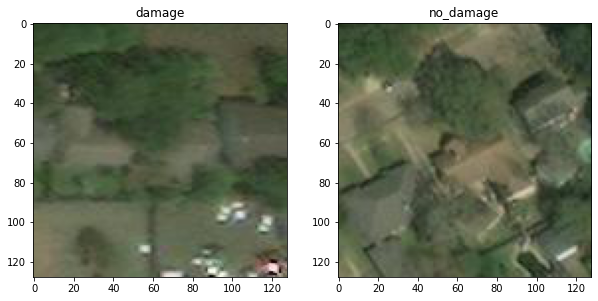

In [133]:
# Visualizing train image samples with different labels
classes = train.class_names
plt.figure(figsize=(10,10))
for x in range(len(classes)):
    plt.subplot(1,2,x+1)
    image = plt.imread(str(list(train_data_dir.glob(classes[x]+'/*.jpeg'))[0]))
    plt.title(classes[x])
#     plt.axis('off')
    plt.imshow(image)

**Observations:**
- Image data contains RGB image samples with dimensions (128,128,3)

In [134]:
### Creating dataframe with path and labels for unbalanced test dataset
# Set the root directory to path
root_dir = '/kaggle/input/post-hurricane/test_another'

# Initialize a list to store the data (tuples of image path and label)
data = []

# Walk through all subdirectories in the root directory
for root, dirs, files in os.walk(root_dir):
    # Get the label for the current directory (assuming the directory name is the label)
    label = os.path.basename(root)
    
    # For each file in the current directory
    for file in files:
        # If the file is an image file
        if file.endswith('.jpeg') or file.endswith('.png'):
            # Add the full path and label to the list of data
            data.append((os.path.join(root, file), label))

# Create a dataframe from the list of data, with columns 'image_path' and 'label'
path_df = pd.DataFrame(data, columns=['image_path', 'label'])
# Display the dataframe
path_df.head(10)

image_path   label
0  /kaggle/input/post-hurricane/test_another/dama...  damage
1  /kaggle/input/post-hurricane/test_another/dama...  damage
2  /kaggle/input/post-hurricane/test_another/dama...  damage
3  /kaggle/input/post-hurricane/test_another/dama...  damage
4  /kaggle/input/post-hurricane/test_another/dama...  damage
5  /kaggle/input/post-hurricane/test_another/dama...  damage
6  /kaggle/input/post-hurricane/test_another/dama...  damage
7  /kaggle/input/post-hurricane/test_another/dama...  damage
8  /kaggle/input/post-hurricane/test_another/dama...  damage
9  /kaggle/input/post-hurricane/test_another/dama...  damage

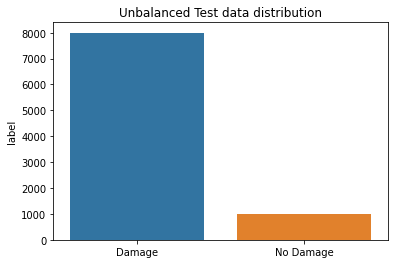

In [135]:
# viewing imbalance in unbalaced test dataset
import seaborn as sns
imbalance = path_df.label.value_counts()
sns.barplot(['Damage','No Damage'],imbalance)
plt.title('Unbalanced Test data distribution')
plt.show()

# Data Preprossesing Functions :
- Defining functions

In [136]:
# creating functions for plotting the accuracy and loss
def plot_acc_loss(history_name,title_string):
    fig, ax = plt.subplots(1,2,figsize = (16,6))
    #Loss plot
    ax[0].plot(history_name.history['loss'],color='#EFAEA4',label = 'Training Loss')
    ax[0].plot(history_name.history['val_loss'],color='#B2D7D0',label = 'Validation Loss')
    ax[0].legend()
    ax[0].set_xlabel('Epochs', fontsize=18)
    ax[0].set_ylabel('Loss', fontsize=18)
    #Accuracy plot
    ax[1].plot(history_name.history['accuracy'],color='#EFAEA4',label = 'Training Accuracy')
    ax[1].plot(history_name.history['val_accuracy'],color='#B2D7D0',label = 'Validation Accuracy')
    ax[1].legend()
    ax[1].set_xlabel('Epochs', fontsize=18);
    ax[1].set_ylabel('Accuracy', fontsize=18);
    fig.suptitle(title_string, fontsize = 24)

In [137]:
# #----------------------------------------------------------------------------------------------------------------------#
# def create_image_generator(model_type):
# #     if type(model_type) == str:
#         if model_type == "cnn":
#             train_datagen_cnn = ImageDataGenerator(rescale = 1./255,
#                         rotation_range = 90,
#                         width_shift_range = 0.1,
#                         brightness_range=(0.3,0.9),
#                         height_shift_range = 0.1,
#                         shear_range = 0.2,
#                         zoom_range = 0.2,vertical_flip = False,
#                         horizontal_flip = False,)
#             val_datagen_cnn = ImageDataGenerator(rescale = 1./255)
#             test_datagen_cnn = ImageDataGenerator(rescale = 1./255)
#             print("Use following instances")
#             print("1. train_datagen_cnn")
#             print("2. val_datagen_cnn")
#             print("3. test_datagen_cnn")
#         elif model_type == "resnet50":
#             train_datagen_resnet50 = ImageDataGenerator(rescale = 1./255,
#                         rotation_range = 90,
#                         width_shift_range = 0.1,
#                         brightness_range=(0.3,0.9),
#                         height_shift_range = 0.1,
#                         shear_range = 0.2,
#                         zoom_range = 0.2,vertical_flip = False,
#                         horizontal_flip = False,
#                         preprocessing_function=tf.keras.applications.resnet.preprocess_input)
#             val_datagen_resnet50 = ImageDataGenerator(rescale = 1./255,preprocessing_function=tf.keras.applications.resnet.preprocess_input)
#             test_datagen_resnet50 = ImageDataGenerator(rescale = 1./255,preprocessing_function=tf.keras.applications.resnet.preprocess_input)
#             print("Use following instances")
#             print("1. train_datagen_resnet50")
#             print("2. val_datagen_resnet50")
#             print("3. test_datagen_resnet50")
#         elif model_type == "xception":
#             train_datagen_xception = ImageDataGenerator(rescale = 1./255,
#                         rotation_range = 90,
#                         width_shift_range = 0.1,
#                         brightness_range=(0.3,0.9),
#                         height_shift_range = 0.1,
#                         shear_range = 0.2,
#                         zoom_range = 0.2,vertical_flip = False,
#                         horizontal_flip = False,
#                         preprocessing_function=tf.keras.applications.xception.preprocess_input)
#             val_datagen_xception = ImageDataGenerator(rescale = 1./255,preprocessing_function=tf.keras.applications.xception.preprocess_input)
#             test_datagen_xception= ImageDataGenerator(rescale = 1./255,preprocessing_function=tf.keras.applications.xception.preprocess_input)
#             print("Use following instances are ready to be used")
#             print("1. train_datagen_xception")
#             print("2. val_datagen_xception")
#             print("3. test_datagen_xception")
#         elif model_type == "vgg16":
#             train_datagen_vgg16 = ImageDataGenerator(rescale = 1./255,
#                         rotation_range = 90,
#                         width_shift_range = 0.1,
#                         brightness_range=(0.3,0.9),
#                         height_shift_range = 0.1,
#                         shear_range = 0.2,
#                         zoom_range = 0.2,vertical_flip = False,
#                         horizontal_flip = False,
#                         preprocessing_function=tf.keras.applications.vgg16.preprocess_input)
#             val_datagen_vgg16 = ImageDataGenerator(rescale = 1./255,preprocessing_function=tf.keras.applications.vgg16.preprocess_input)
#             test_datagen_vgg16= ImageDataGenerator(rescale = 1./255,preprocessing_function=tf.keras.applications.vgg16.preprocess_input)
#             print("Use following instances")
#             print("1. train_datagen_vgg16")
#             print("2. val_datagen_vgg16")
#             print("3. test_datagen_vgg16") 
#         else:
#             print("You have passed a new model which is not avalible in function. Please create a custon Image data generator")
# #     else:
# #         print("Please pass the following models_types in string formate : cnn,resnet50, xception,vgg16")
        

In [138]:
# def cnn_testing_accuracy(model_name):
#     y_test_eval = model_name.evaluate(test_datagen_cnn.flow_from_directory(test_data_dir,target_size=(128, 128),class_mode = 'binary',save_format='jpeg',shuffle = True),verbose = 0)
#     y_unbal_test_eval = model_name.evaluate(test_datagen_cnn.flow_from_directory(unbal_test_data_dir,target_size=(128, 128),class_mode = 'binary',save_format='jpeg',shuffle = True),verbose = 0)
#     print("Accuracy of balanced test data in CNN",y_test_eval[1])
#     print("Accuracy of unbalanced test data CNN",y_unbal_test_eval[1])



In [139]:
# creating functions for balanced and unbalanced test accuracies
def testing_accuracy(model_name,datagen):
        y_test_eval = model_name.evaluate(datagen.flow_from_directory(test_data_dir,target_size=(128, 128),class_mode = 'binary',save_format='jpeg',shuffle = False),verbose = 0)
        y_unbal_test_eval = model_name.evaluate(datagen.flow_from_directory(unbal_test_data_dir,target_size=(128, 128),class_mode = 'binary',save_format='jpeg',shuffle = False),verbose = 0)
        print(f"Accuracy of balanced test data in {model_name} is {y_test_eval[1]:.4f}")
        print(f"Accuracy of unbalanced test data in {model_name} is {y_unbal_test_eval[1]:.4f}")
    

In [156]:
# creating functions for dataset building with paths and labels
def get_two_images_of_unbalanced_test(model_name,testgen):
    Y_predict_unbal = model_name.predict(testgen.flow_from_directory(unbal_test_data_dir,target_size=(128, 128),class_mode = 'binary',save_format='jpeg',shuffle = False))
    y_pred_unbal_test_rounded = (np.round_(Y_predict_unbal)).astype(int)
    
    index_not_classified = []
    indexs = [i for i in range(0, 9000)]
    for i in range(len(y_pred_unbal_test_rounded)):
        if y_test_unbal[i] != y_pred_unbal_test_rounded[i]:
            index_not_classified.append(i)
        i +=1
    index_classified = [x for x in indexs if x not in index_not_classified]
    
    rand_index_not_classified = np.random.choice(index_not_classified)
    rand_index_classified = np.random.choice(index_classified)
   
    # Set the root directory to search
    root_dir = '/kaggle/input/post-hurricane/test_another'

    # Initialize a list to store the data (tuples of image path and label)
    data = []

    # Walk through all subdirectories in the root directory
    for root, dirs, files in os.walk(root_dir):
        # Get the label for the current directory (assuming the directory name is the label)
        label = os.path.basename(root)

        # For each file in the current directory
        for file in files:
            # If the file is an image file
            if file.endswith('.jpeg') or file.endswith('.png'):
                # Add the full path and label to the list of data
                data.append((os.path.join(root, file), label))

    # Create a dataframe from the list of data, with columns 'image_path' and 'label'
    df = pd.DataFrame(data, columns=['image_path', 'label'])
#     df["labels"] = y_test_unbal
    
    print("1. Correctly classified image path :", df["image_path"][rand_index_classified])
    print("2. Incorrectly classified image path :", df["image_path"][rand_index_not_classified])

    return df["image_path"][rand_index_classified],df["image_path"][rand_index_not_classified]

In [160]:
# Creating and defining functions for visualizing the feature maps/activation maps 
def create_feature_maps(model_name,layer_number,image_name):
    model_f = Model(inputs=model_name.inputs , outputs=model_name.layers[layer_number].output)
    
    image_ = load_img(image_name, target_size=(128,128))
    # convert the image to an array
    image = img_to_array(image_)
    # expand dimensions so that it represents a single 'sample'
    image = np.expand_dims(image, axis=0)
    feature_maps = model_f.predict(image)
    size_of_grid= 5
    z = 0
    fig,ax = plt.subplots(5,5,figsize=(12, 12))
    ax = ax.ravel()
    for i in range(size_of_grid*size_of_grid):
        ax[i].imshow(feature_maps[0,:,:,z],cmap='inferno')
        ax[i].axis('off')
        ax[i].set_title(f"Filter: {i}")
        z+=1
    ax[12].imshow(image_)
    ax[12].axis('off')
    ax[12].set_title("Original image")

In [176]:
# Creating functions for modelevaluation through ROC_AUC and F1 score
def testing_roc_f1_score(model_name,data_gen):
    predict_x = model_name.predict(data_gen.flow_from_directory(unbal_test_data_dir,target_size=(128, 128),class_mode = 'binary',save_format='jpeg',shuffle = False),verbose = 0)
    y_pred_test_rounded = (np.round_(predict_x)).astype(int)
    cfm = confusion_matrix(y_test_unbal, y_pred_test_rounded)
    sns.heatmap(cfm/np.sum(cfm), annot=True,fmt='.2%', cmap='Blues')
    plt.title('Confusion Matrix', color='g')
    plt.show()
    recall = (cfm[1][1])/cfm.sum(axis=1)[1]
#     fpr = (cm[0][1])/cm.sum(axis=1)[1]
#     tpr = (cm[0][0])/cm.sum(axis=1)[0]
    precision = (cfm[1][1])/cfm.sum(axis=0)[1]
    f1_score = (2*precision*recall)/(recall+precision)
    predict_x1=predict_x[:,0]
    auc = roc_auc_score(y_test_unbal,predict_x1)    
    fp_rate, tp_rate, thresholds = roc_curve(y_test_unbal,y_pred_test_rounded )
    return f1_score,auc,fp_rate,tp_rate

# Model Building :

## Baseline CNN Model :

### Data Preprocessing for baseline cnn model :

In [18]:
# creating Data generators for baseline model
## train data generators
train_datagen_cnn = ImageDataGenerator(rescale = 1./255,
                        rotation_range = 90,
                        width_shift_range = 0.1,
                        brightness_range=(0.3,0.9),
                        height_shift_range = 0.1,
                        shear_range = 0.2,
                        zoom_range = 0.2,vertical_flip = False,
                        horizontal_flip = False)
## validation data generators
val_datagen_cnn = ImageDataGenerator(rescale = 1./255)
## test data generators
test_datagen_cnn = ImageDataGenerator(rescale = 1./255)

### Model building for the Baseline CNN model

In [19]:
#Baseline model building 
cnn = Sequential(name = 'baseline_model')

cnn.add(layers.Conv2D(32, (3,3), input_shape=(128, 128, 3), activation='relu'))
cnn.add(layers.MaxPooling2D(2,2))
cnn.add(layers.Conv2D(64, (3,3), activation='relu'))
cnn.add(layers.MaxPooling2D(2,2))

cnn.add(layers.Flatten())
cnn.add(layers.Dense(1,activation = "sigmoid"))

# initiating optimizer for baseline model
cnn.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001), metrics = ['accuracy'])

# model architecture
cnn.summary()

Model: "baseline_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 57600)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 57601     
Total params: 76,993
Trainable params: 76,993
Non-trainable params: 0
________________________________________________

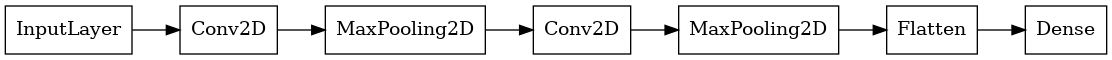

In [193]:
# Model architecture
keras.utils.plot_model(
    cnn,
    to_file='baseline_model.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=False,
    rankdir='LR',
    expand_nested=False,
    dpi=96,
    layer_range=None)

In [20]:
# training the baseline model
%%time
history_baseline = cnn.fit(train_datagen_cnn.flow_from_directory(train_data_dir, target_size=(128, 128),class_mode = 'binary',save_format='jpeg'),epochs = 20,batch_size =64, validation_data = val_datagen_cnn.flow_from_directory(val_data_dir,target_size=(128, 128),class_mode = 'binary',save_format='jpeg'))

Found 10000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Epoch 1/20


2022-12-19 06:49:05.355935: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


313/313 [==============================] - 68s 195ms/step - loss: 0.5585 - accuracy: 0.7208 - val_loss: 0.5520 - val_accuracy: 0.6800
Epoch 2/20
313/313 [==============================] - 64s 203ms/step - loss: 0.4289 - accuracy: 0.8194 - val_loss: 0.3341 - val_accuracy: 0.8895
Epoch 3/20
313/313 [==============================] - 61s 194ms/step - loss: 0.3607 - accuracy: 0.8588 - val_loss: 0.3885 - val_accuracy: 0.8815
Epoch 4/20
313/313 [==============================] - 65s 208ms/step - loss: 0.3190 - accuracy: 0.8798 - val_loss: 0.3828 - val_accuracy: 0.8805
Epoch 5/20
313/313 [==============================] - 62s 199ms/step - loss: 0.2952 - accuracy: 0.8866 - val_loss: 0.5596 - val_accuracy: 0.7275
Epoch 6/20
313/313 [==============================] - 65s 207ms/step - loss: 0.2820 - accuracy: 0.8914 - val_loss: 0.3025 - val_accuracy: 0.9160
Epoch 7/20
313/313 [==============================] - 62s 197ms/step - loss: 0.2753 - accuracy: 0.8932 - val_loss: 0.6352 - val_accuracy: 0.7

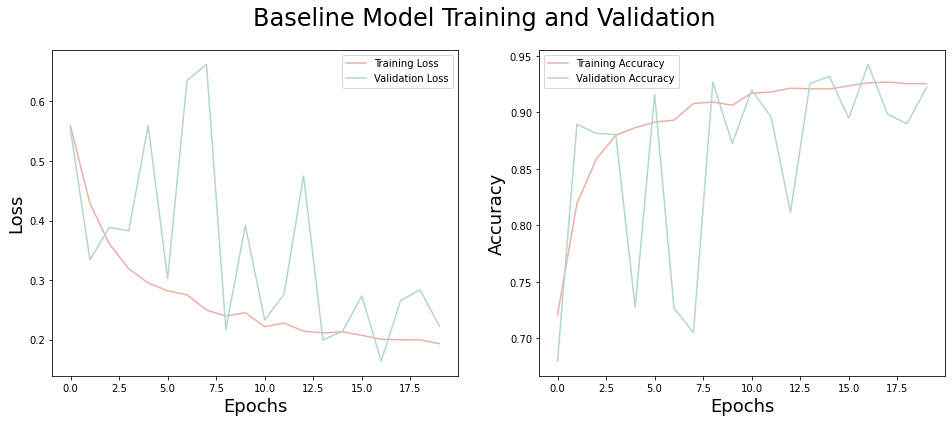

In [22]:
# visualizing the train and validation accuracy and loss plot
plot_acc_loss(history_baseline,'Baseline Model Training and Validation')

### Baseline model evaluation :

In [46]:
# test the accuracy of the baseline moodel on balanced and unbalanced test datasets
testing_accuracy(cnn,test_datagen_cnn)

Found 2000 images belonging to 2 classes.
Found 9000 images belonging to 2 classes.
Accuracy of balanced test data in <keras.engine.sequential.Sequential object at 0x7fefc0027a90> is 0.9125
Accuracy of unbalanced test data in <keras.engine.sequential.Sequential object at 0x7fefc0027a90> is 0.9634


In [23]:
# saving the baseline cnn model weights
cnn.save_weights('cnn_baseline_weights.h5')

Found 2000 images belonging to 2 classes.
Found 9000 images belonging to 2 classes.
Accuracy of balanced test data in <keras.engine.sequential.Sequential object at 0x7fefc0027a90> is 0.9125
Accuracy of unbalanced test data in <keras.engine.sequential.Sequential object at 0x7fefc0027a90> is 0.9634
Found 9000 images belonging to 2 classes.


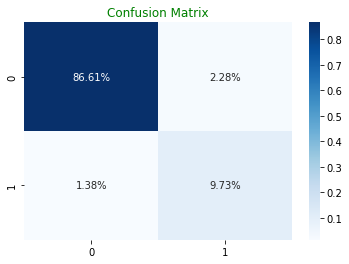

F1 score for CNN is 0.8419
ROC_AUC score for CNN is 0.9757


In [177]:
# testing the model on balanced and unbalanced datasets
# ROC_AUC and F1 scores are used as evaluation matrices
testing_accuracy(cnn,test_datagen_cnn) 
roc_f1_cnn=testing_roc_f1_score(cnn,test_datagen_cnn)
print("F1 score for CNN is",round(roc_f1_cnn[0],4))
print("ROC_AUC score for CNN is",round(roc_f1_cnn[1],4))

**Observation :**
- we can observe from the plot that our baseline model `flactuates` rapidly
- issue of overfitting is not that observable but the model performence is not consistant.
- we can build our custom model with `more convolution layers` and and we can tryout `dropout layers` too
- we can apply `regularization techniques` to make the model stable

## Custom CNN Model :

### Data Preprocessing for the Custom CNN model

In [25]:
# Creating data generator for custom cnn model
## train data generators
train_datagen_cnn = ImageDataGenerator(rescale = 1./255,
                        rotation_range = 90,
                        width_shift_range = 0.1,
                        brightness_range=(0.3,0.9),
                        height_shift_range = 0.1,
                        shear_range = 0.2,
                        zoom_range = 0.2,vertical_flip = False,
                        horizontal_flip = False)
## valiidation data generators
val_datagen_cnn = ImageDataGenerator(rescale = 1./255)
## test data generators
test_datagen_cnn = ImageDataGenerator(rescale = 1./255)

### Model building for the Custom CNN model

In [29]:
# Custom CNN Model building
custom_cnn = Sequential(name = 'Custom_CNN')
custom_cnn.add(layers.Conv2D(32,(3,3),input_shape=(128,128,3),activation='relu',padding='same'))
custom_cnn.add(layers.MaxPooling2D(2,2))
custom_cnn.add(layers.Conv2D(32,(3,3),activation='relu',padding='same'))
custom_cnn.add(layers.MaxPooling2D(2,2))
# custom_cnn.add(layers.Dropout(0.3))
custom_cnn.add(layers.Conv2D(64,(3,3),activation='relu',padding='same'))
custom_cnn.add(layers.MaxPooling2D(2,2))
custom_cnn.add(layers.Conv2D(64,(3,3),activation='relu',padding='same'))
custom_cnn.add(layers.MaxPooling2D(2,2))
# custom_cnn.add(layers.Dropout(0.3))
custom_cnn.add(layers.Conv2D(128,(3,3),activation='relu',padding='same'))
custom_cnn.add(layers.MaxPooling2D(2,2))
# custom_cnn.add(layers.Dropout(0.3))
custom_cnn.add(layers.Flatten())
custom_cnn.add(layers.Dense(256,activation='relu',kernel_regularizer=l2(0.1)))
custom_cnn.add(layers.Dense(1,activation='sigmoid'))

# initiating the optimizer
custom_cnn.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
# visualizing the model architecture
custom_cnn.summary()

Model: "Custom_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 64)        3

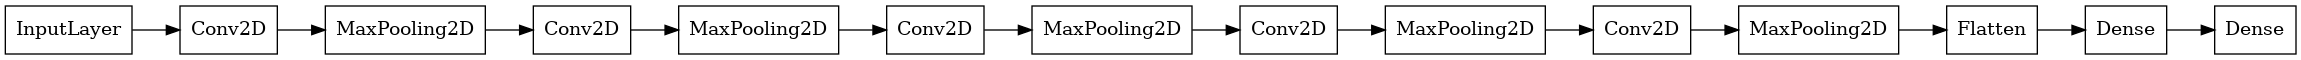

In [196]:
# Model architecture
keras.utils.plot_model(
    custom_cnn,
    to_file='custom_cnn_model.png',
    show_shapes=0,
    show_dtype=False,
    show_layer_names=False,
    rankdir='LR',
    expand_nested=False,
    dpi=96,
    layer_range=None)

In [30]:
# Creating the callbacks
## we have used earlyStopping and ReduceLROnPlateau as callbcks
%%time
LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1,
                      mode="min", epsilon=0.0001,
                      cooldown=0, min_lr=0.00001)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True)
# Training the custom cnn model
history_1 = custom_cnn.fit(train_datagen_cnn.flow_from_directory(train_data_dir, target_size=(128, 128),class_mode = 'binary',save_format='jpeg'),
                      epochs = 30,
                      validation_data = val_datagen_cnn.flow_from_directory(val_data_dir,target_size=(128, 128),class_mode = 'binary',save_format='jpeg'),
                     callbacks=[callback,LR])

Found 10000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Epoch 1/30
313/313 [==============================] - 63s 198ms/step - loss: 20.6637 - accuracy: 0.6578 - val_loss: 6.6800 - val_accuracy: 0.5960
Epoch 2/30
313/313 [==============================] - 60s 193ms/step - loss: 2.7984 - accuracy: 0.7578 - val_loss: 0.9985 - val_accuracy: 0.7830
Epoch 3/30
313/313 [==============================] - 63s 202ms/step - loss: 0.6565 - accuracy: 0.7846 - val_loss: 0.5412 - val_accuracy: 0.8005
Epoch 4/30
313/313 [==============================] - 60s 192ms/step - loss: 0.4628 - accuracy: 0.8103 - val_loss: 0.5017 - val_accuracy: 0.8175
Epoch 5/30
313/313 [==============================] - 60s 191ms/step - loss: 0.4240 - accuracy: 0.8323 - val_loss: 0.6342 - val_accuracy: 0.6885
Epoch 6/30
313/313 [==============================] - 61s 193ms/step - loss: 0.3890 - accuracy: 0.8514 - val_loss: 0.4237 - val_accuracy: 0.8480
Epoch 7/30
313/313 [========================

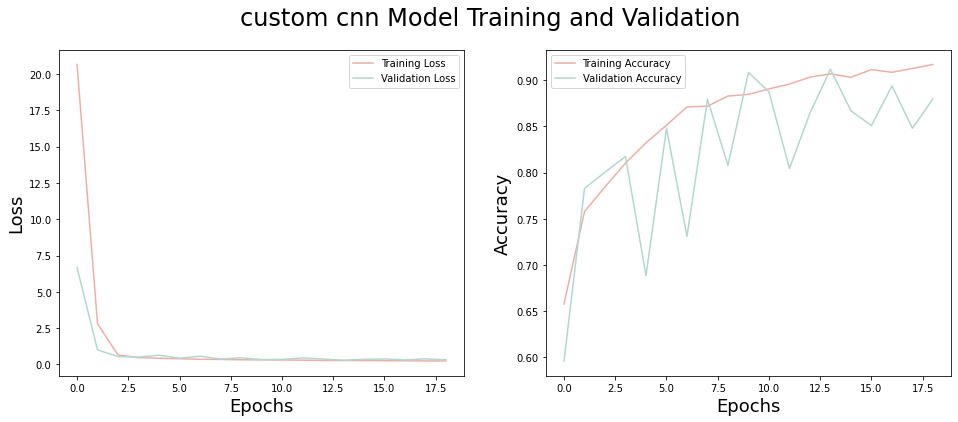

In [31]:
# Visualizing the training and validation accuracy and loss for the custom cnn model
plot_acc_loss(history_1,'custom cnn Model Training and Validation')

In [33]:
# Saving the weights of custom cnn model for future use
custom_cnn.save_weights('cnn_custom_weights.h5')

In [34]:
# Loading the custom cnn model weights
# custom_cnn.load_weights("/kaggle/input/customcnnposthurrweight/cnn_custom_weights.h5")

### Custom CNN Model Evaluation

Found 2000 images belonging to 2 classes.
Found 9000 images belonging to 2 classes.
Accuracy of balanced test data in <keras.engine.sequential.Sequential object at 0x7fea4df20c10> is 0.9390
Accuracy of unbalanced test data in <keras.engine.sequential.Sequential object at 0x7fea4df20c10> is 0.9648
Found 9000 images belonging to 2 classes.


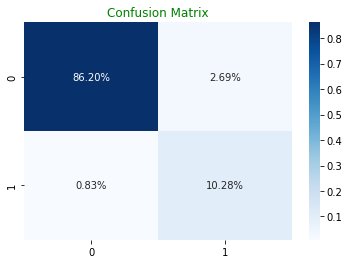

F1 score for CNN_custom is 0.8537
ROC_AUC score for CNN_custom is 0.9862


In [194]:
# testing the model on balanced and unbalanced datasets
# ROC_AUC and F1 scores are used as evaluation matrices
testing_accuracy(custom_cnn,test_datagen_cnn)
roc_f1_cnn_custom=testing_roc_f1_score(custom_cnn,test_datagen_cnn)
print("F1 score for CNN_custom is",round(roc_f1_cnn_custom[0],4))
print("ROC_AUC score for CNN_custom is",round(roc_f1_cnn_custom[1],4))

**Observation :**
- we can observe from the plot that our custom cnn model that flactuation in `loss is reduced`.
- for the best epoch issue of overfitting is not observable but the model struggles with validation dataset.
- we can use `transfer learning models` for better predictions
- we can use VGG16, `RESNET50`, InceptionV3, MobileNet, `Xception` Models.
- Before that we should observe the `feature/activation` maps and `Saliency maps` for better understanding of the model performance
- we are going to use `SmoothGrad` and `GradCam` to visualize saliency mapping

### Feature maps for Custom CNN Model

#### Correctly classified images

Found 9000 images belonging to 2 classes.
1. Correctly classified image path : /kaggle/input/post-hurricane/test_another/damage/-95.636994_29.843798.jpeg
2. Incorrectly classified image path : /kaggle/input/post-hurricane/test_another/damage/-95.635929_29.846764.jpeg


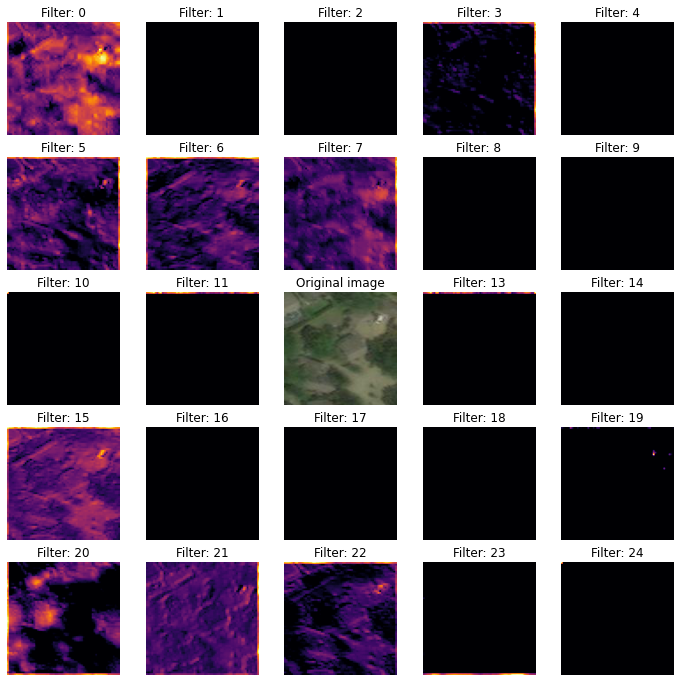

In [162]:
# Feature maps for correctly classified images
create_feature_maps(custom_cnn,1,get_two_images_of_unbalanced_test(custom_cnn,test_datagen_cnn)[0])

#### Incorrectly classified images

Found 9000 images belonging to 2 classes.
1. Correctly classified image path : /kaggle/input/post-hurricane/test_another/damage/-95.656665_29.836571999999997.jpeg
2. Incorrectly classified image path : /kaggle/input/post-hurricane/test_another/damage/-95.636771_29.773384999999998.jpeg


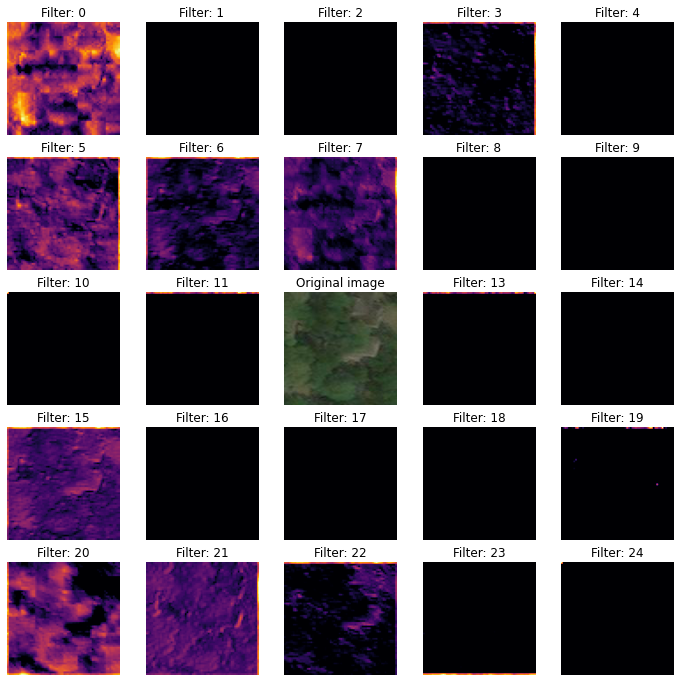

In [163]:
# Feature maps for incorrectly classified images
create_feature_maps(custom_cnn,1,get_two_images_of_unbalanced_test(custom_cnn,test_datagen_cnn)[1])

### Saliency maps for correctly classified images :

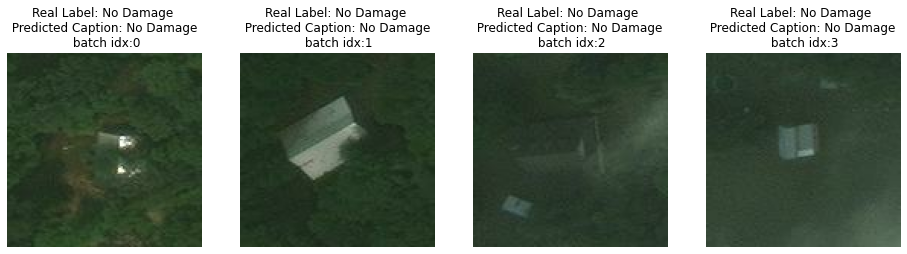

Correctly Predicted indexes are :  [0, 1, 2, 3]


In [38]:
#Correct Predictions
caption_dict={0:'No Damage',1:'Damage'}
corr_idx = []
count=0
plt.figure(figsize=(16,12))
for items, labels in unbal_test.take(1):
    for idx in range(64):
        img = np.expand_dims(items[idx], axis=0)
        pred = np.round_(custom_cnn.predict(img))[0][0].astype(int)
        lab = np.array(labels[idx])[0].astype(int)
        if pred == lab:
            corr_idx.append(idx)
            plt.subplot(1, 4, count + 1)
            plt.imshow(items[idx].numpy().astype("uint8"))    
            plt.title(f'Real Label: {caption_dict[lab]} \n Predicted Caption: {caption_dict[pred]} \n batch idx:{idx}')
            plt.axis("off")
            count = count+1
            if count==4:
                break
plt.show()
print('Correctly Predicted indexes are : ', corr_idx)   

#### SmoothGrad:

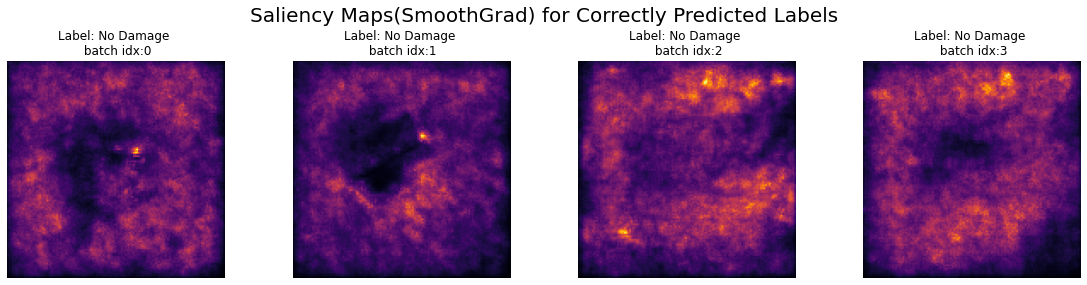

In [39]:
## SmoothGrad

replace2linear = ReplaceToLinear()
score = BinaryScore([0,0,0,0]) # or BinaryScore(True) 

# from tf_keras_vis.utils import normalize
saliency = Saliency(custom_cnn,
                    model_modifier=replace2linear,
                    clone=True)

# Generate saliency map
img1 = np.array(items[0])
img2 = np.array(items[1])
img3 = np.array(items[2])
img4 = np.array(items[3])
images = np.asarray([img1,img2,img3,img4])
X = images/255.0
saliency_map = saliency(score, X,
                        smooth_samples=30, # The number of calculating gradients iterations.
                        smooth_noise=0.20) # noise spread level.

# Render
f, ax = plt.subplots(nrows=1, ncols=len(corr_idx), figsize=(16, 4))
for i, value in enumerate(corr_idx):
    ax[i].set_title(f'Label: {caption_dict[0]} \n batch idx:{value}', fontsize=12)
    ax[i].imshow(saliency_map[i], cmap='inferno')
    ax[i].axis('off')
plt.suptitle('Saliency Maps(SmoothGrad) for Correctly Predicted Labels',fontsize=20)
plt.tight_layout()
plt.show()

#### GradCAM:

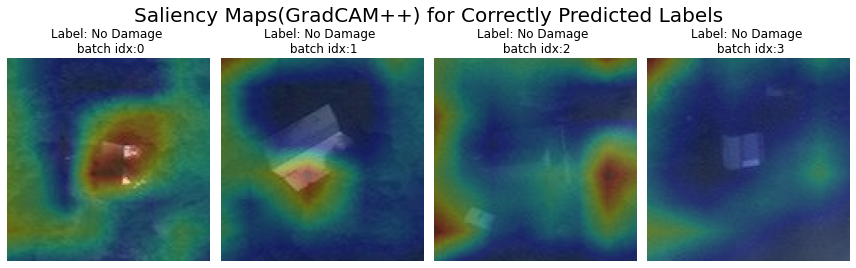

In [40]:
## Grad-CAM++
from matplotlib import cm
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus

gradcam = GradcamPlusPlus(custom_cnn,
                  model_modifier=replace2linear,
                  clone=True)

# Generate heatmap with GradCAM
heatmap = gradcam(score,
              X,
              penultimate_layer=-1)


# Render
f, ax = plt.subplots(nrows=1, ncols=len(corr_idx), figsize=(12, 4))
for i, title in enumerate(corr_idx):
    heatmap_ = np.uint8(cm.jet(heatmap[i])[..., :3] * 255)
    ax[i].set_title(f'Label: {caption_dict[0]} \n batch idx:{title}', fontsize=12)
    ax[i].imshow(items[i].numpy().astype("uint8"))
    ax[i].imshow(heatmap_, cmap='inferno', alpha=0.3) # overlay
    ax[i].axis('off')
plt.suptitle('Saliency Maps(GradCAM++) for Correctly Predicted Labels',fontsize=20)
plt.tight_layout()
plt.show()

**Observations :**
- here model gets `accurate predictions` on non damage properties.
- we can see from the smoothgrad that the `surrounding area of houses` are triggering the predictions.
- gradCam gives us more `intuative visualization` and proves our observations

### Saliency maps for incorrectly classified images

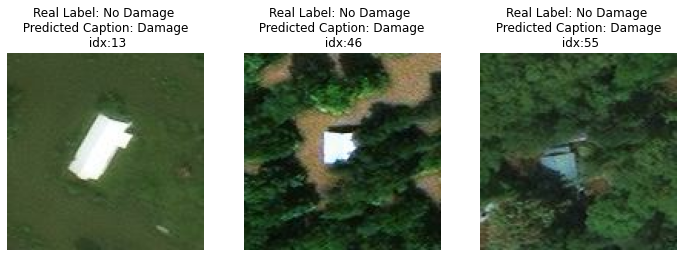

Incorrectly Predicted indexes are :  [13, 46, 55]


In [41]:
#incorrect predictions
caption_dict={0:'No Damage',1:'Damage'}
inc_idx = []
count=0
plt.figure(figsize=(12,10))
for items, labels in unbal_test.take(1):
    for idx in range(64):
        img = np.expand_dims(items[idx], axis=0)
        pred = np.round_(custom_cnn.predict(img))[0][0].astype(int)
        lab = np.array(labels[idx])[0].astype(int)
        if pred != lab:
            inc_idx.append(idx)
            plt.subplot(1, 3, count + 1)
            plt.imshow(items[idx].numpy().astype("uint8"))    
            plt.title(f'Real Label: {caption_dict[lab]} \n Predicted Caption: {caption_dict[pred]} \n idx:{idx}')
            plt.axis("off")
            count = count+1
            if count==3:
                break

plt.show()                
print('Incorrectly Predicted indexes are : ', inc_idx)        

#### SmoothGrad:

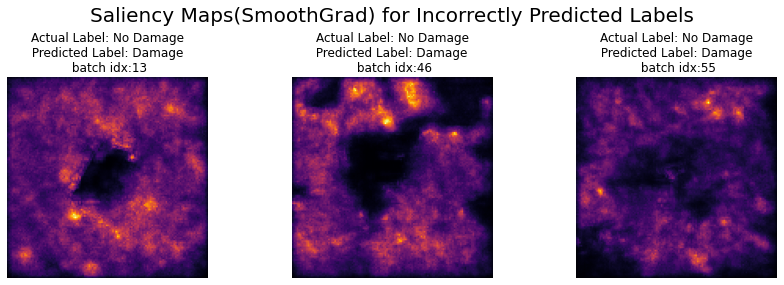

In [42]:
## SmoothGrad
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import BinaryScore
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
from tensorflow.keras.applications.vgg16 import preprocess_input

replace2linear = ReplaceToLinear()
score = BinaryScore([1,1,1]) # or BinaryScore(True) 

# from tf_keras_vis.utils import normalize
saliency = Saliency(custom_cnn,
                    model_modifier=replace2linear,
                    clone=True)

# Generate saliency map
img1 = np.array(items[13])
img2 = np.array(items[46])
img3 = np.array(items[55])
images = np.asarray([img1,img2,img3])
X = images/255.0
saliency_map = saliency(score, X,
                        smooth_samples=30, # The number of calculating gradients iterations.
                        smooth_noise=0.20) # noise spread level.

# Render
f, ax = plt.subplots(nrows=1, ncols=len(inc_idx), figsize=(12, 4))
for i, value in enumerate(inc_idx):
    ax[i].set_title(f'Actual Label: {caption_dict[0]}\n Predicted Label: {caption_dict[1]} \n batch idx:{value}', fontsize=12)
    ax[i].imshow(saliency_map[i], cmap='inferno')
    ax[i].axis('off')
plt.suptitle('Saliency Maps(SmoothGrad) for Incorrectly Predicted Labels',fontsize=20)
plt.tight_layout()
plt.show()

#### GradCAM:

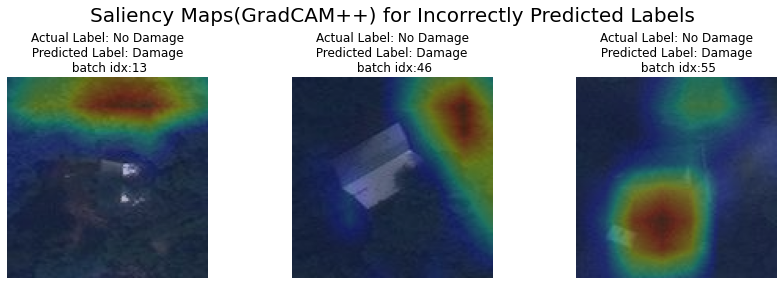

In [43]:
## Grad-CAM++
from matplotlib import cm
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus

gradcam = GradcamPlusPlus(custom_cnn,
                  model_modifier=replace2linear,
                  clone=True)

# Generate heatmap with GradCAM
heatmap = gradcam(score,
              X,
              penultimate_layer=-1)


# Render
f, ax = plt.subplots(nrows=1, ncols=len(inc_idx), figsize=(12, 4))
for i, title in enumerate(inc_idx):
    heatmap_ = np.uint8(cm.jet(heatmap[i])[..., :3] * 255)
    ax[i].set_title(f'Actual Label: {caption_dict[0]}\n Predicted Label: {caption_dict[1]} \n batch idx:{title}', fontsize=12)
    ax[i].imshow(items[i].numpy().astype("uint8"))
    ax[i].imshow(heatmap_, cmap='inferno', alpha=0.3) # overlay
    ax[i].axis('off')
plt.suptitle('Saliency Maps(GradCAM++) for Incorrectly Predicted Labels',fontsize=20)
plt.tight_layout()
plt.show()

**Observations :**
- here model gets `inaccurate predictions` on non damage properties.
- we can see from the smoothgrad that the `surrounding area of houses` are `not getting into` model activation and receptor field
- hence `misclassifies` and `flag` them as damaged properties.
- gradCam gives us more `intuative visualization` and proves our observations

## Transfer Learning Models:

## 1. ResNet50 Model(Custom) :

- ResNet stands for Residual Network and is a specific type of convolutional neural network (CNN) introduced in the 2015 paper “Deep Residual Learning for Image Recognition” by He Kaiming, Zhang Xiangyu, Ren Shaoqing, and Sun Jian. CNNs are commonly used to power computer vision applications.

- ResNet-50 is a 50-layer convolutional neural network (48 convolutional layers, one MaxPool layer, and one average pool layer). Residual neural networks are a type of artificial neural network (ANN) that forms networks by stacking residual blocks.
![ResNet50 Model Architecture](https://www.researchgate.net/publication/349717475/figure/fig4/AS:996933933993986@1614698980245/The-architecture-of-ResNet-50-model.ppm)

### Data Preprocessing for the ResNet50 model

In [51]:
# Creating data generators for ResNet50 model
## train data generators
train_datagen_resnet50 = ImageDataGenerator(rescale = 1./255,
                        rotation_range = 90,
                        width_shift_range = 0.1,
                        brightness_range=(0.3,0.9),
                        height_shift_range = 0.1,
                        shear_range = 0.2,
                        zoom_range = 0.2,vertical_flip = False,
                        horizontal_flip = False,
                        preprocessing_function=tf.keras.applications.resnet.preprocess_input)
## validation data generators
val_datagen_resnet50 = ImageDataGenerator(rescale = 1./255,preprocessing_function=tf.keras.applications.resnet.preprocess_input)
## test data generators
test_datagen_resnet50 = ImageDataGenerator(rescale = 1./255,preprocessing_function=tf.keras.applications.resnet.preprocess_input)

### Model building for the ResNet50 model

In [52]:
# importing ResNet50 from keras applications
resnet_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(128,128,3),
    pooling=None,
    classes=2,
)

In [53]:
# Creating the Custom ResNet50 model
Flattened_output = layers.Flatten()(resnet_model.output)
dense_1 = layers.Dense(1024,kernel_regularizer=regularizers.L2(0.1),activation='relu')(Flattened_output)
dense_2 = layers.Dense(512,kernel_regularizer=regularizers.L2(0.1),activation='relu')(dense_1)
# dense_3 = layers.Dense(256,kernel_regularizer=regularizers.L2(0.1),activation='relu')(dense_2)
final_layer = layers.Dense(1,activation='sigmoid')(dense_2)
resnet50_model = Model(inputs= resnet_model.input,outputs=final_layer)
resnet50_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy'])

In [182]:
## Model architecture
# keras.utils.plot_model(
#     resnet50_model,
#     to_file='resnet50_model.png',
#     show_shapes=False,
#     show_dtype=False,
#     show_layer_names=False,
#     rankdir='TB',
#     expand_nested=False,
#     dpi=96,
#     layer_range=None)

In [54]:
# Creating the callbacks
## we have used earlyStopping and ReduceLROnPlateau as callbcks
CL = tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=5,restore_best_weights=True,)
LRs = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1,patience=2,verbose=1,mode="auto")

In [55]:
# Training the ResNet50 model
%%time
history_resnet50 = resnet50_model.fit(train_datagen_resnet50.flow_from_directory(train_data_dir, target_size=(128, 128),class_mode = 'binary',save_format='jpeg'),epochs = 10,batch_size = 64,validation_data = val_datagen_resnet50.flow_from_directory(val_data_dir,target_size=(128, 128),class_mode = 'binary',save_format='jpeg'),callbacks=[CL,LRs])

Found 10000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Epoch 1/10
313/313 [==============================] - 80s 238ms/step - loss: 74.0023 - accuracy: 0.9196 - val_loss: 16.8756 - val_accuracy: 0.5115
Epoch 2/10
313/313 [==============================] - 73s 232ms/step - loss: 7.4944 - accuracy: 0.9648 - val_loss: 3.5937 - val_accuracy: 0.4105
Epoch 3/10
313/313 [==============================] - 71s 226ms/step - loss: 1.1068 - accuracy: 0.9766 - val_loss: 1.5280 - val_accuracy: 0.5140
Epoch 4/10
313/313 [==============================] - 71s 226ms/step - loss: 0.1811 - accuracy: 0.9799 - val_loss: 0.1138 - val_accuracy: 0.9765
Epoch 5/10
313/313 [==============================] - 71s 226ms/step - loss: 0.0859 - accuracy: 0.9829 - val_loss: 0.1118 - val_accuracy: 0.9680
Epoch 6/10
313/313 [==============================] - 71s 227ms/step - loss: 0.0739 - accuracy: 0.9827 - val_loss: 0.0828 - val_accuracy: 0.9785
Epoch 7/10
313/313 [=======================

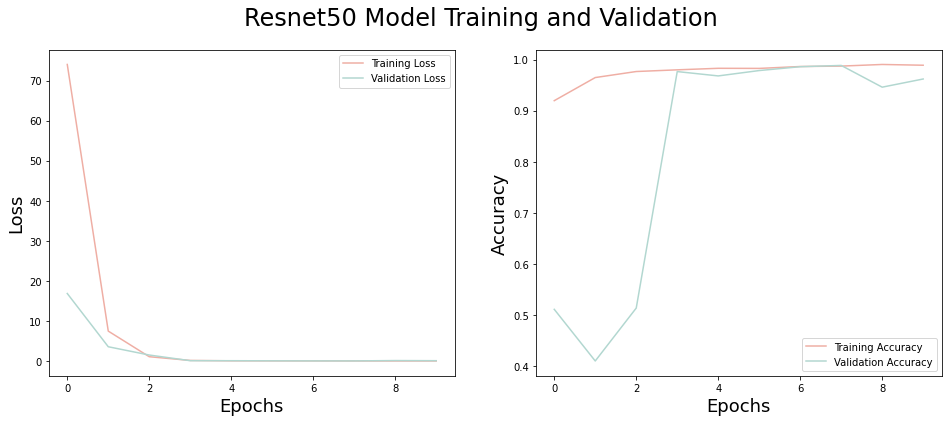

In [56]:
# Visualizing the training and validation accuracy and loss for the ResNet50 model
plot_acc_loss(history_resnet50,'Resnet50 Model Training and Validation')

### ResNet50 Model Evaluation

Found 2000 images belonging to 2 classes.
Found 9000 images belonging to 2 classes.
Accuracy of balanced test data in <keras.engine.functional.Functional object at 0x7fea45299dd0> is 0.9750
Accuracy of unbalanced test data in <keras.engine.functional.Functional object at 0x7fea45299dd0> is 0.9818
Found 9000 images belonging to 2 classes.


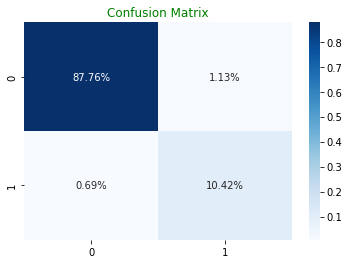

F1 score for ResNet50 is 0.9196
ROC_AUC score for ResNet50 is 0.9961


In [195]:
# testing the model on balanced and unbalanced datasets
# ROC_AUC and F1 scores are used as evaluation matrices
testing_accuracy(resnet50_model,test_datagen_resnet50)
roc_f1_resnet50=testing_roc_f1_score(resnet50_model,test_datagen_resnet50)
print("F1 score for ResNet50 is",round(roc_f1_resnet50[0],4))
print("ROC_AUC score for ResNet50 is",round(roc_f1_resnet50[1],4))

In [58]:
# Saving the weights of ResNet50 model for future use
resnet50_model.save_weights('resnet50_model_weights.h5')

**Observations :**
- ResNet50 model reduces the `loss very efficiently` and with `no overfitting`.
- reduceing learning rate of optimizer whenever platues has helped to boost the model accuracy further
- this model is `good improvement` over our custom CNN model so far
- Now we will try an advanced model(Xception)

## Xception Model(Custom) :

-  Xception model is a depthwise separable convolution can be understood as an Inception module with a maximally large number of towers. This observation leads a novel deep convolutional neural network architecture inspired by Inception, where Inception modules have been replaced with depthwise separable convolutions. We show that this architecture, dubbed Xception, slightly outperforms Inception V3 on the ImageNet dataset (which Inception V3 was designed for), and significantly outperforms Inception V3 on a larger image classification dataset comprising 350 million images and 17,000 classes. Since the Xception architecture has the same number of parameters as Inception V3, the performance gains are not due to increased capacity but rather to a more efficient use of model parameters.
![Xception Model Architecture](https://www.researchgate.net/publication/351371226/figure/fig2/AS:1020996995792897@1620436061199/Architecture-of-the-Xception-deep-CNN-model.jpg)

### Data Preprocessing for the Xception model

In [68]:
# Creating data generators for Xception model
## train data generator
train_datagen_xception = ImageDataGenerator(rescale = 1./255,
                        rotation_range = 90,
                        width_shift_range = 0.1,
                        brightness_range=(0.3,0.9),
                        height_shift_range = 0.1,
                        shear_range = 0.2,
                        zoom_range = 0.2,vertical_flip = False,
                        horizontal_flip = False,
                        preprocessing_function=tf.keras.applications.xception.preprocess_input)
## validation data generator
val_datagen_xception = ImageDataGenerator(rescale = 1./255,preprocessing_function=tf.keras.applications.xception.preprocess_input)
## test data generator
test_datagen_xception= ImageDataGenerator(rescale = 1./255,preprocessing_function=tf.keras.applications.xception.preprocess_input)

### Model building for the Xception model

In [69]:
# importing Xception from keras applications
xception = tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(128,128,3),
    pooling=None,
    classes=2,
)

83697664/83683744 [==============================] - 4s 0us/step


In [70]:
# Creating the Custom Xception model
Flattened_output = layers.Flatten()(xception.output)
dense_1 = layers.Dense(1024,activation='relu')(Flattened_output)
dense_2 = layers.Dense(512,activation='relu')(dense_1)
# dense_3 = layers.Dense(256,kernel_regularizer=regularizers.L2(0.1),activation='relu')(dense_2)
final_layer = layers.Dense(1,activation='sigmoid')(dense_2)
xception_model = Model(inputs= xception.input,outputs=final_layer)
xception_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy'])
#model layers
xception_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 63, 63, 32)   864         input_4[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 63, 63, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 63, 63, 32)   0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [186]:
# # Model architecture
# keras.utils.plot_model(
#     xception_model,
#     to_file='resnet50_model.png',
#     show_shapes=False,
#     show_dtype=False,
#     show_layer_names=True,
#     rankdir='TB',
#     expand_nested=False,
#     dpi=96,
#     layer_range=None)

In [71]:
# Creating the callbacks
## we have used earlyStopping and ReduceLROnPlateau as callbcks

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True)
LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1,
                      mode="min", epsilon=0.0001,
                      cooldown=0, min_lr=0.00001)

In [72]:
# Training the Xception model
%%time
history_xception = xception_model.fit(train_datagen_xception.flow_from_directory(train_data_dir, target_size=(128, 128),class_mode = 'binary',save_format='jpeg'),epochs = 10,batch_size = 128,validation_data = val_datagen_xception.flow_from_directory(val_data_dir,target_size=(128, 128),class_mode = 'binary',save_format='jpeg'),callbacks=[callback,LR])


Found 10000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Epoch 1/10
313/313 [==============================] - 77s 233ms/step - loss: 0.2386 - accuracy: 0.9037 - val_loss: 0.6415 - val_accuracy: 0.6225
Epoch 2/10
313/313 [==============================] - 72s 230ms/step - loss: 0.1052 - accuracy: 0.9602 - val_loss: 0.1013 - val_accuracy: 0.9595
Epoch 3/10
313/313 [==============================] - 71s 227ms/step - loss: 0.0769 - accuracy: 0.9691 - val_loss: 0.0891 - val_accuracy: 0.9645
Epoch 4/10
313/313 [==============================] - 71s 228ms/step - loss: 0.0567 - accuracy: 0.9794 - val_loss: 0.0855 - val_accuracy: 0.9705
Epoch 5/10
313/313 [==============================] - 71s 226ms/step - loss: 0.0469 - accuracy: 0.9829 - val_loss: 0.0948 - val_accuracy: 0.9645
Epoch 6/10
313/313 [==============================] - 71s 227ms/step - loss: 0.0350 - accuracy: 0.9866 - val_loss: 0.1044 - val_accuracy: 0.9730

Epoch 00006: ReduceLROnPlateau reducing lear

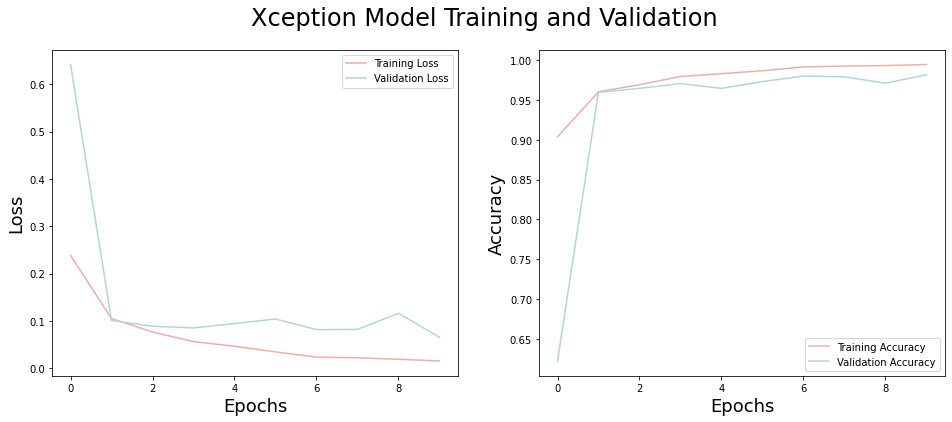

In [74]:
# Visualizing the training and validation accuracy and loss for the Xception model
plot_acc_loss(history_xception,'Xception Model Training and Validation')

In [75]:
# Saving the weights of Xception model for future use
xception_model.save_weights('xception_model_weights.h5')

In [76]:
# loading the Xception model weights for predictions
# xception_model.load_weights('/kaggle/input/xception-posthurr-weight/xception_model_weights.h5')

### Xception Model Evaluation

Found 2000 images belonging to 2 classes.
Found 9000 images belonging to 2 classes.
Accuracy of balanced test data in <keras.engine.functional.Functional object at 0x7fe9dea71110> is 0.9890
Accuracy of unbalanced test data in <keras.engine.functional.Functional object at 0x7fe9dea71110> is 0.9896
Found 9000 images belonging to 2 classes.


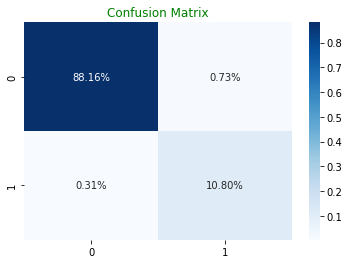

F1 score for Xception is 0.9538763493621197
ROC_AUC score for Xception is 0.9990803749999999


In [197]:
# testing the model on balanced and unbalanced datasets
# ROC_AUC and F1 scores are used as evaluation matrices
testing_accuracy(xception_model,test_datagen_xception)
roc_f1_xception=testing_roc_f1_score(xception_model,test_datagen_xception)
print("F1 score for Xception is",roc_f1_xception[0])
print("ROC_AUC score for Xception is",roc_f1_xception[1])

**Observations :**
- Xception model also shows `no overfitting`
- the acuuracy of the model on `train`, `validation`, `balanced and unbalanced test` dataset **~99%**.
- this Xception model is the **best model** so far.

### Feature maps for Xception Model

#### Correctly classified images

Found 9000 images belonging to 2 classes.
1. Correctly classified image path : /kaggle/input/post-hurricane/test_another/damage/-95.572616_29.758430999999998.jpeg
2. Incorrectly classified image path : /kaggle/input/post-hurricane/test_another/damage/-95.531371_29.74813.jpeg


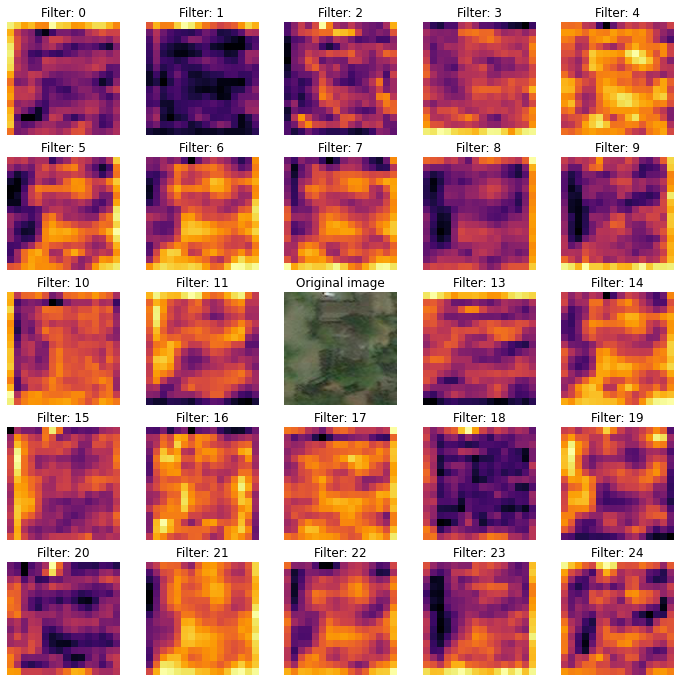

In [164]:
#correctly classified images
create_feature_maps(xception_model,31,get_two_images_of_unbalanced_test(xception_model,test_datagen_xception)[0])

#### Incorrectly classified images

Found 9000 images belonging to 2 classes.
1. Correctly classified image path : /kaggle/input/post-hurricane/test_another/damage/-95.163719_29.429835999999998.jpeg
2. Incorrectly classified image path : /kaggle/input/post-hurricane/test_another/damage/-95.638531_29.843390999999997.jpeg


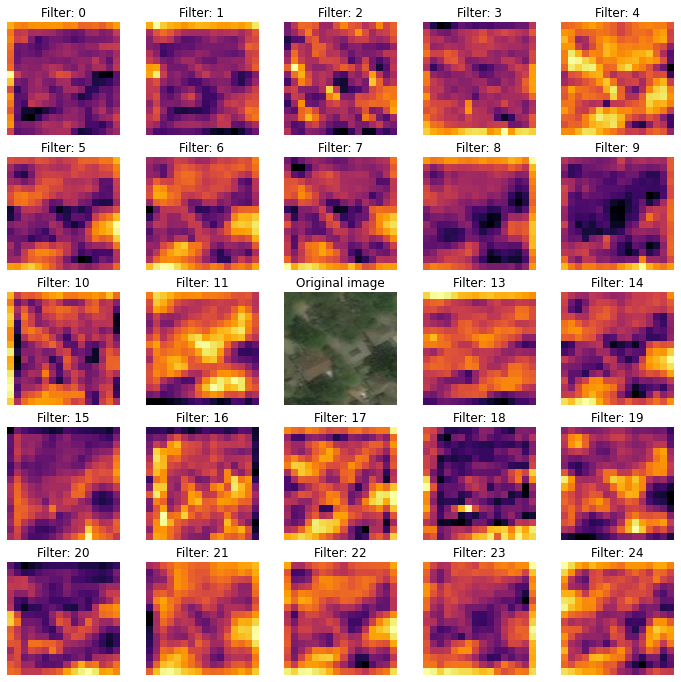

In [165]:
# incorrectly classified images
create_feature_maps(xception_model,31,get_two_images_of_unbalanced_test(xception_model,test_datagen_xception)[1])

### Saliency maps for correctly classified images :

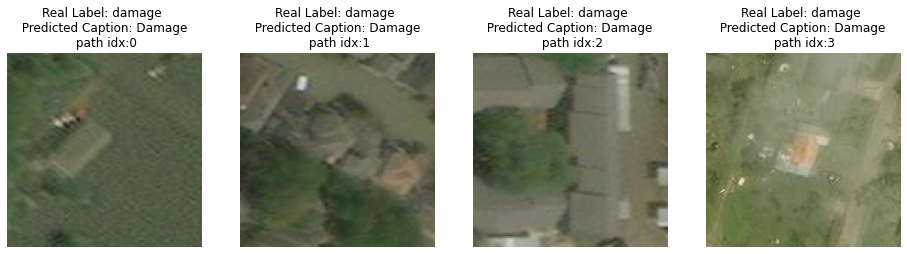

Correctly Predicted indexes are :  [0, 1, 2, 3]


In [81]:
# Correctly predicted images
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.xception import preprocess_input
caption={0:'no_damage',1:'damage'}
caption_dict={0:'No Damage',1:'Damage'}
corr_idx=[]
count=0
plt.figure(figsize=(16,12))
for i in range(path_df.shape[0]):
    image = load_img(path_df['image_path'][i],target_size=(128,128))
    img = np.asarray(image)
    img = img/255.0
    img = preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    y_pred = xception_model.predict(img)
    pred = np.round_(y_pred).astype(int)
    if path_df.label[i]==caption[pred[0][0]]:
        corr_idx.append(i)
        plt.subplot(1, 4, count + 1)
        plt.imshow(image)
        plt.title(f'Real Label: {path_df.label[i]} \n Predicted Caption: {caption_dict[pred[0][0]]} \n path idx:{i}')
        plt.axis("off")
        count = count+1
        if len(corr_idx)==4:
            break

plt.show()           
print('Correctly Predicted indexes are : ', corr_idx)

#### SmoothGrad:

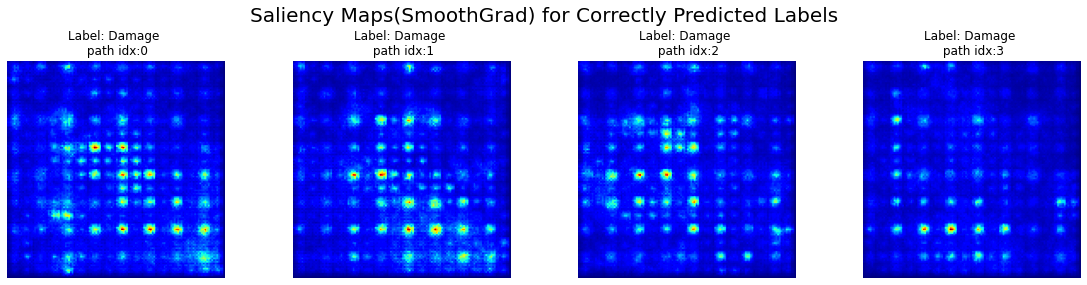

In [82]:
## SmoothGrad
from tensorflow.keras.preprocessing.image import load_img
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import BinaryScore
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
from tensorflow.keras.applications.xception import preprocess_input

replace2linear = ReplaceToLinear()
score = BinaryScore([1,1,1,1]) # or BinaryScore(True) 

# from tf_keras_vis.utils import normalize
saliency = Saliency(xception_model,
                    model_modifier=replace2linear,
                    clone=True)

# Generate saliency map
img1 = load_img(path_df['image_path'][corr_idx[0]],target_size=(128,128))
img2 = load_img(path_df['image_path'][corr_idx[1]],target_size=(128,128))
img3 = load_img(path_df['image_path'][corr_idx[2]],target_size=(128,128))
img4 = load_img(path_df['image_path'][corr_idx[3]],target_size=(128,128))
images = np.asarray([np.array(img1), np.array(img2), np.array(img3), np.array(img4)])
X = preprocess_input(images)
saliency_map = saliency(score, X,
                        smooth_samples=30, # The number of calculating gradients iterations.
                        smooth_noise=0.20) # noise spread level.

# Render
f, ax = plt.subplots(nrows=1, ncols=len(corr_idx), figsize=(16, 4))
for i, value in enumerate(corr_idx):
    ax[i].set_title(f'Label: {caption_dict[1]} \n path idx:{value}', fontsize=12)
    ax[i].imshow(saliency_map[i], cmap='jet')
    ax[i].axis('off')
plt.suptitle('Saliency Maps(SmoothGrad) for Correctly Predicted Labels',fontsize=20)
plt.tight_layout()
plt.show()

#### GradCAM:

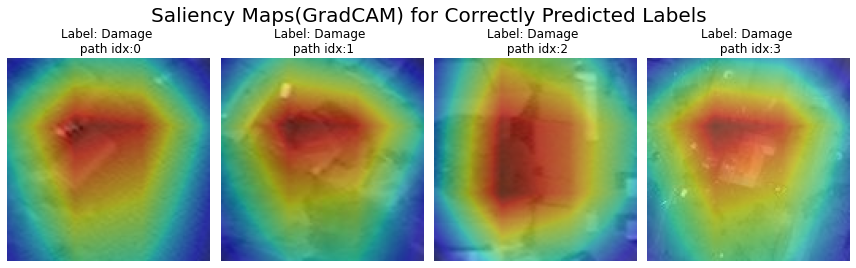

In [83]:
## Grad-CAM
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

gradcam = Gradcam(xception_model,
                  model_modifier=replace2linear,
                  clone=True)

# Generate heatmap with GradCAM
heatmap = gradcam(score,
              X,
              penultimate_layer=-1)


# Render
f, ax = plt.subplots(nrows=1, ncols=len(corr_idx), figsize=(12, 4))
for i, title in enumerate(corr_idx):
    heatmap_ = np.uint8(cm.jet(heatmap[i])[..., :3] * 255)
    ax[i].set_title(f'Label: {caption_dict[1]} \n path idx:{title}', fontsize=12)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap_, cmap='inferno', alpha=0.5) # overlay
    ax[i].axis('off')
plt.suptitle('Saliency Maps(GradCAM) for Correctly Predicted Labels',fontsize=20)
plt.tight_layout()
plt.show()

**Observations :**
- The Xception model gets `accurate prediction` on damage properties.
- From the above SmoothGrad and GradCAM observation we can see that the `houses and the surrounding areas` together triggering the receptor field most for correct damage prediction. 

### Saliency maps for incorrectly classified images :

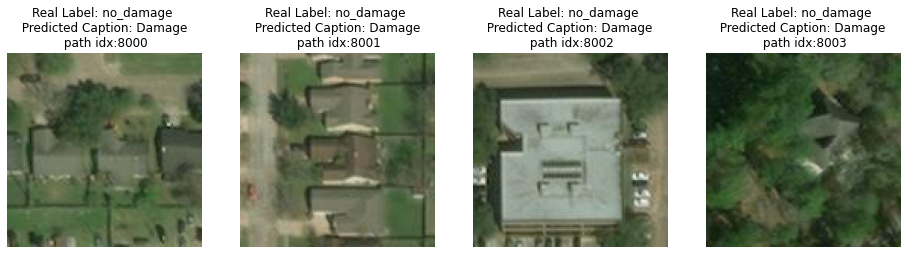

Incorrectly Predicted indexes are :  [8000, 8001, 8002, 8003]


In [84]:
# Inorrectly predicted images
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.xception import preprocess_input
caption={0:'no_damage',1:'damage'}
caption_dict={0:'No Damage',1:'Damage'}
inc_idx=[]
count=0
plt.figure(figsize=(16,12))
for i in range(8000,8900):
    image = load_img(path_df['image_path'][i],target_size=(128,128))
    img = np.asarray(image)
    img = img/255.0
    img = preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    y_pred = xception_model.predict(img)
    pred = np.round_(y_pred).astype(int)
    if path_df.label[i]!=caption[pred[0][0]]:
        inc_idx.append(i)
        plt.subplot(1, 4, count+1)
        plt.imshow(image)
        plt.title(f'Real Label: {path_df.label[i]} \n Predicted Caption: {caption_dict[pred[0][0]]} \n path idx:{i}')
        plt.axis("off")
        count = count+1
        if len(inc_idx)==4:
            break

plt.show()           
print('Incorrectly Predicted indexes are : ', inc_idx)

#### SmoothGrad:

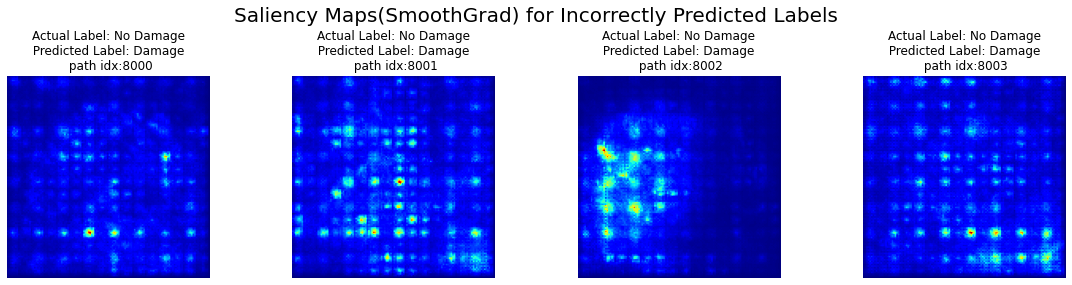

In [85]:
## SmoothGrad
from tensorflow.keras.preprocessing.image import load_img
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import BinaryScore
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
from tensorflow.keras.applications.xception import preprocess_input

replace2linear = ReplaceToLinear()
score = BinaryScore([1,1,1,1]) # or BinaryScore(True) 

# from tf_keras_vis.utils import normalize
saliency = Saliency(xception_model,
                    model_modifier=replace2linear,
                    clone=True)

# Generate saliency map
img1 = load_img(path_df['image_path'][inc_idx[0]],target_size=(128,128))
img2 = load_img(path_df['image_path'][inc_idx[1]],target_size=(128,128))
img3 = load_img(path_df['image_path'][inc_idx[2]],target_size=(128,128))
img4 = load_img(path_df['image_path'][inc_idx[3]],target_size=(128,128))
images = np.asarray([np.array(img1), np.array(img2), np.array(img3), np.array(img4)])
X = preprocess_input(images)
saliency_map = saliency(score, X,
                        smooth_samples=30, # The number of calculating gradients iterations.
                        smooth_noise=0.20) # noise spread level.

# Render
f, ax = plt.subplots(nrows=1, ncols=len(inc_idx), figsize=(16, 4))
for i, value in enumerate(inc_idx):
    ax[i].set_title(f'Actual Label: {caption_dict[0]}\n Predicted Label: {caption_dict[1]} \n path idx:{value}', fontsize=12)
    ax[i].imshow(saliency_map[i], cmap='jet')
    ax[i].axis('off')
plt.suptitle('Saliency Maps(SmoothGrad) for Incorrectly Predicted Labels',fontsize=20)
plt.tight_layout()
plt.show()


#### GradCAM:

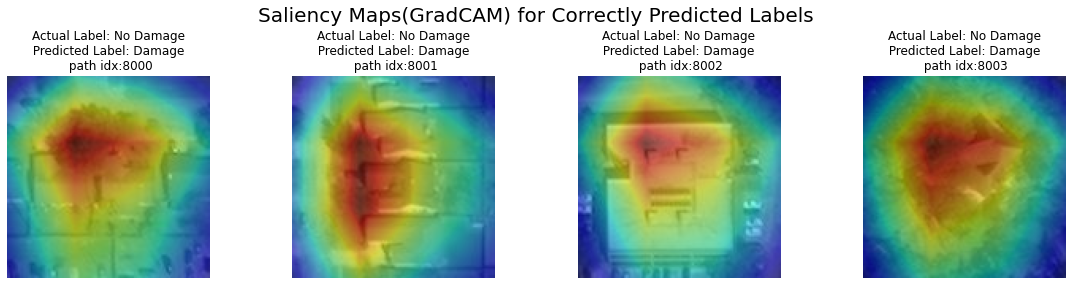

In [86]:
## Grad-CAM
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

gradcam = Gradcam(xception_model,
                  model_modifier=replace2linear,
                  clone=True)

# Generate heatmap with GradCAM
heatmap = gradcam(score,
              X,
              penultimate_layer=-1)


# Render
f, ax = plt.subplots(nrows=1, ncols=len(inc_idx), figsize=(16, 4))
for i, value in enumerate(inc_idx):
    heatmap_ = np.uint8(cm.jet(heatmap[i])[..., :3] * 255)
    ax[i].set_title(f'Actual Label: {caption_dict[0]}\n Predicted Label: {caption_dict[1]} \n path idx:{value}', fontsize=12)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap_, cmap='inferno', alpha=0.5) # overlay
    ax[i].axis('off')
plt.suptitle('Saliency Maps(GradCAM) for Correctly Predicted Labels',fontsize=20)
plt.tight_layout()
plt.show()

**Observations :**
- The Xception model gets `inaccurate prediction` on non damage properties.
- From the above SmoothGrad and GradCAM observation we can see that the `houses and the surrounding areas` together triggering the receptor field most for `correct damage prediction`. **But here `images with houses and environments are pretty indistinguishable` which triggers the `incorrect classification` on the no damage properties**

# Model Comaparisons :
- Comparison of `ROC curve` through all the Models
- `F1 Score` Comparison through all the Models

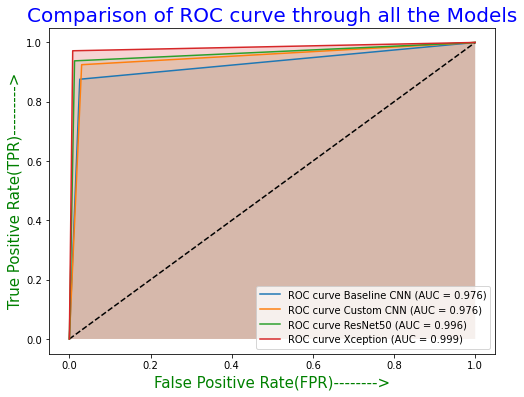

In [122]:
# Comparison of ROC curve through all the Models
plt.figure(figsize=[8,6])
plt.plot([0, 1], [0, 1], 'k--')  # Base line
plt.plot(roc_f1_cnn[2], roc_f1_cnn[3], label='ROC curve Baseline CNN (AUC = {:.3f})'.format(roc_f1_cnn[1]))
plt.fill_between(roc_f1_cnn[2],roc_f1_cnn[3], alpha=0.1)

plt.plot(roc_f1_cnn_custom[2], roc_f1_cnn_custom[3], label='ROC curve Custom CNN (AUC = {:.3f})'.format(roc_f1_cnn[1]))
plt.fill_between(roc_f1_cnn_custom[2], roc_f1_cnn_custom[3], alpha=0.1)

plt.plot(roc_f1_resnet50[2], roc_f1_resnet50[3],label='ROC curve ResNet50 (AUC = {:.3f})'.format(roc_f1_resnet50[1]))
plt.fill_between(roc_f1_resnet50[2], roc_f1_resnet50[3], alpha=0.1)

plt.plot(roc_f1_xception[2], roc_f1_xception[3],label='ROC curve Xception (AUC = {:.3f})'.format(roc_f1_xception[1]))
plt.fill_between(roc_f1_xception[2], roc_f1_xception[3], alpha=0.2)

plt.xlabel('False Positive Rate(FPR)-------->',color='g',fontsize=15)
plt.ylabel('True Positive Rate(TPR)--------->',color='g',fontsize=15)
plt.title('Comparison of ROC curve through all the Models', color='b',fontsize=20)
plt.legend(loc='best')
plt.show()

**Observations :**
- AUC score for the Xception model and ResNet50 model is a `close call`.
- here **Xception model** `tops` the performace wise.

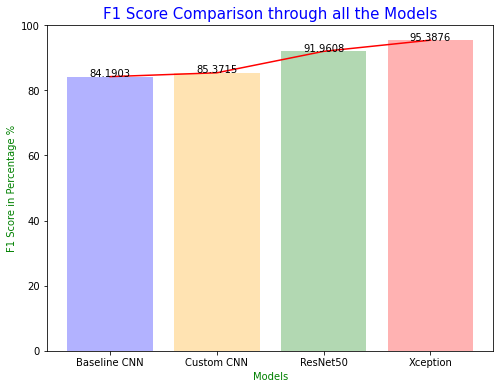

In [249]:
# F1 Score Comparison through all the Models
plt.figure(figsize=[8,6])
xl = ['Baseline CNN','Custom CNN','ResNet50', 'Xception']
yl = [roc_f1_cnn[0],roc_f1_cnn_custom[0],roc_f1_resnet50[0],roc_f1_xception[0]]
for i,j in enumerate(yl):
    yl[i]=j*100

plt.bar(xl,yl,color=['blue','orange','green','red'],alpha=0.3)
for i, v in enumerate(yl):
    plt.text(i, v, str(round(v,4)), ha='center')
plt.plot(yl,color='r')
plt.xlabel('Models',color='g',fontsize=10)
plt.ylabel('F1 Score in Percentage %',color='g',fontsize=10)
plt.title('F1 Score Comparison through all the Models',color='b',fontsize=15)
plt.show()

**Observations :**
- F1 score for the Xception model otperforms ResNet50 model by **~3%**.
- here **Xception model** tops the performace wise.

## Conclusion

1. In **Xception model** the misclassification accuracy is very low **~1%** hence we can declare this model as the Best Model.
2. AUC score for ResNet50 and Xception model is `very close`.
3. F1 score is better for Xception model **(by~3%)** than ResNet50 model.
4. Xception model tooks less amout of time per epoch also **least number of epochs** for optimizing `minimun loss` for our case.
5. We also need to take care for `computational complexity`.
6. We are going to use this **`Custom Xception model`** as our final model.

## Future Improvements

1. We can make the model robust by futher classifying for **type of damage** caused by hurricane.
2. We can also observe that the dataset image names contains particular location as form of longitude and latitude which we can seperate and visualize the **geo-location of the area**, which can further be a regressor problem for prediction of the locations which are/will be most affected if hurricane or similar type of incident hits the area.
3. We can go to some extreme extent by using **ArcGIS** by Esri to automate, evaluate and predict further.